In [1]:
import numpy as np
import cv2
import os,sys
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

In [2]:
camera_cal = './camera_cal/'
output_imgs = './output_images/'
test_imgs = './test_images/'

image size :(1280, 720)


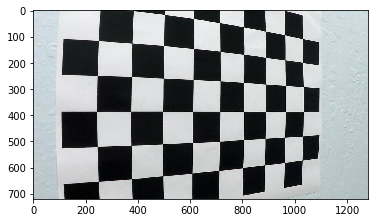

In [3]:
testimg = cv2.imread(camera_cal + 'calibration5.jpg')
nx = 9
ny = 6
imgSize = (testimg.shape[1], testimg.shape[0])
plt.imshow(testimg)
print("image size :{}".format(imgSize))



# Camera Calibration

In [4]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images

#Make a list of calibration images
images = glob.glob(camera_cal + 'calibration*.jpg')

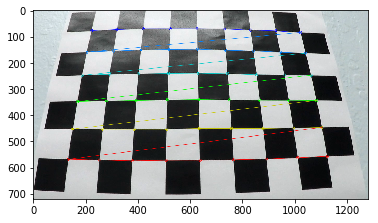

In [5]:
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    
    # If found, add obj points, img points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        plt.imshow(img)


(<matplotlib.axes._subplots.AxesSubplot at 0x7f09af5d7080>,
 <matplotlib.text.Text at 0x7f09af54d198>)

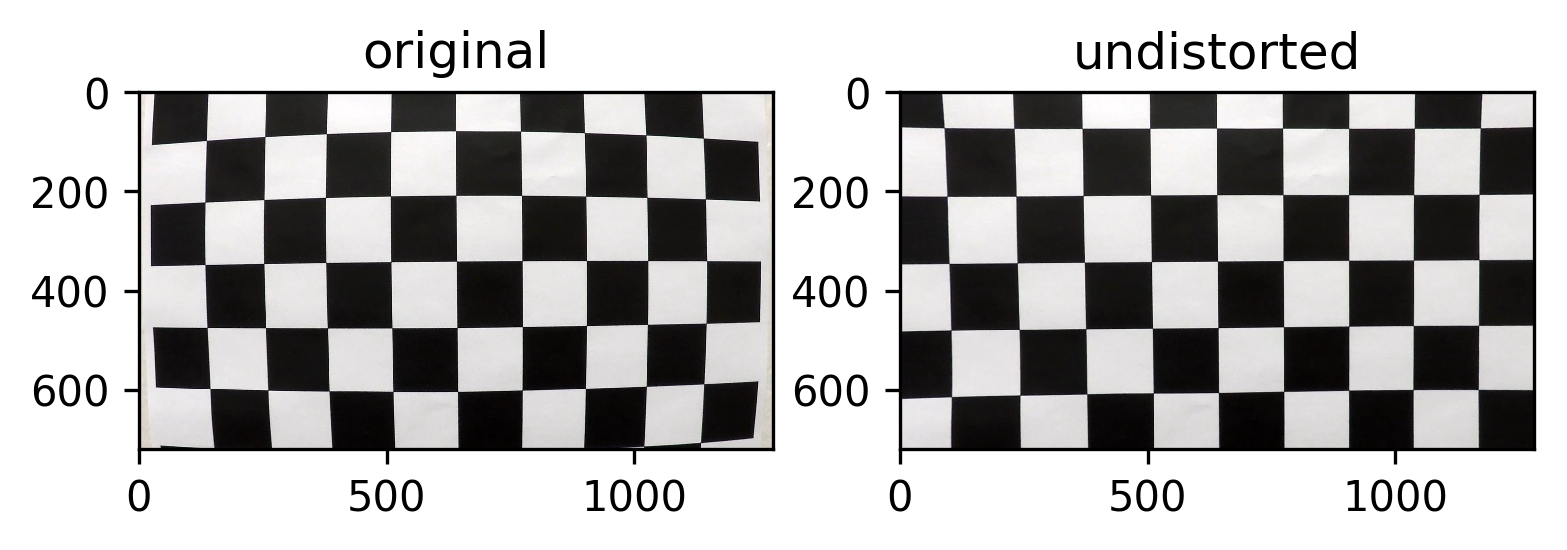

In [6]:
testImg = mpimg.imread(images[5])
imgSize = (img.shape[1], img.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, imgSize, None, None)
testDst = cv2.undistort(testImg, mtx, dist, None, mtx)

plt.figure(dpi=300)
plt.subplot(1,2,1), plt.imshow(testImg), plt.title('original')
plt.subplot(1,2,2), plt.imshow(testDst), plt.title('undistorted')


(<matplotlib.axes._subplots.AxesSubplot at 0x7f09af5dfdd8>,
 <matplotlib.text.Text at 0x7f09a42bac18>)

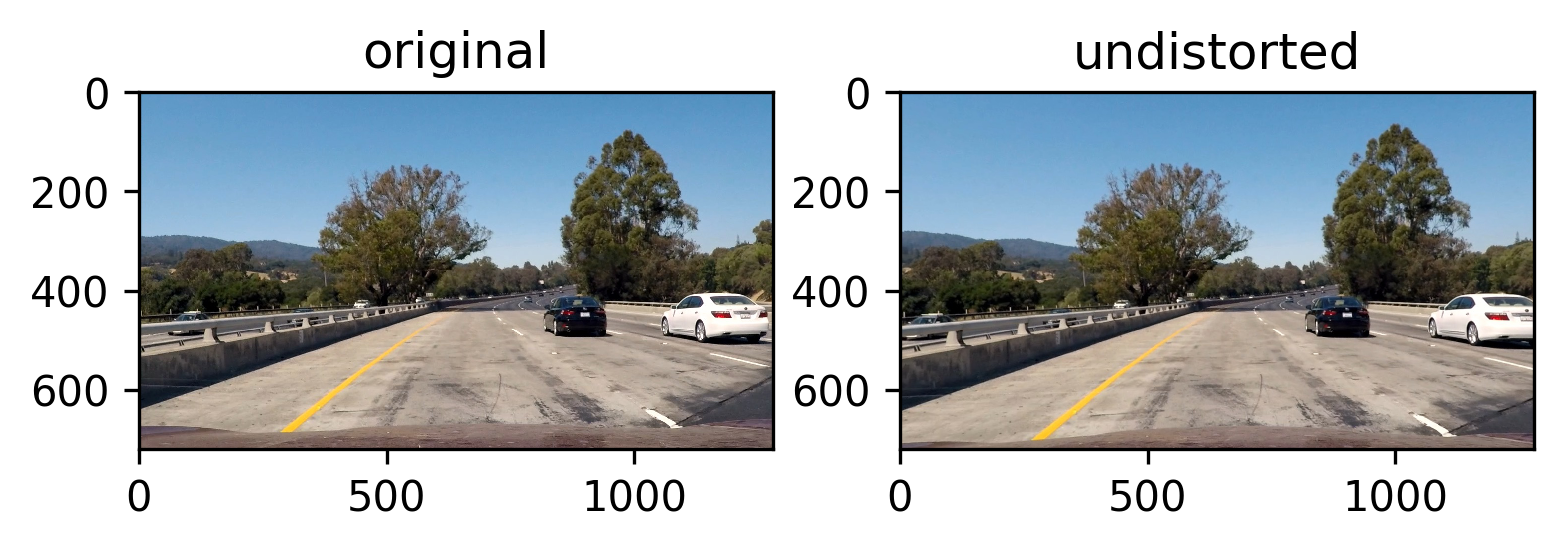

In [7]:
#undistortion image
img = mpimg.imread(test_imgs + "test1.jpg")
#img = mpimg.imread(test_imgs + "straight_lines2.jpg")

imgSize = (img.shape[1], img.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, imgSize, None, None)
dstImage = cv2.undistort(img, mtx, dist, None, mtx)

plt.figure(dpi=300)
plt.subplot(1,2,1), plt.imshow(img), plt.title('original')
plt.subplot(1,2,2), plt.imshow(dstImage), plt.title('undistorted')


# Color space and Threshold

In [8]:
# Color space transform
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    #cvtImg = gray
    cvtImg = hls[:,:,2] #s-channel
    #cvtImg = hsv[:,:,1] #s-channel
    
    if orient=='x':
        sobel = cv2.Sobel(cvtImg, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(cvtImg, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel / np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Apply threshold
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    #cvtImg = gray
    cvtImg = hls[:,:,2] #s-channel
    #cvtImg = hsv[:,:,1] #s-channel
    
    sobelx = cv2.Sobel(cvtImg, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(cvtImg, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Apply threshold
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    #cvtImg = gray
    cvtImg = hls[:,:,2] #s-channel
    #cvtImg = hsv[:,:,1] #s-channel
    
    sobelx = cv2.Sobel(cvtImg, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(cvtImg, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # Apply threshold
    dir_binary = np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return dir_binary


In [9]:
ksize = 15
thresh = (50,150)
dirThresh = (0.7, 1.3)

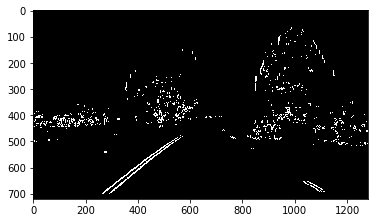

In [10]:
gradx = abs_sobel_thresh(dstImage, orient='x', sobel_kernel=ksize, thresh=(50,150))
plt.imshow(gradx,cmap='gray')

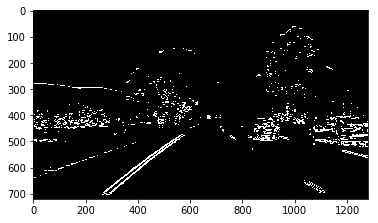

In [11]:
grady = abs_sobel_thresh(dstImage, orient='y', sobel_kernel=ksize, thresh=(50,150))
plt.imshow(grady,cmap='gray')

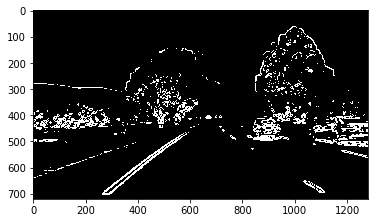

In [12]:
mag_binary = mag_thresh(dstImage, sobel_kernel=ksize, mag_thresh=(50,200))
plt.imshow(mag_binary,cmap='gray')

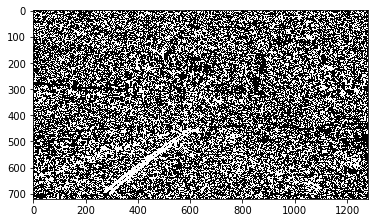

In [13]:
dir_binary = dir_threshold(dstImage, sobel_kernel=ksize, thresh=(0.7,1.3))
plt.imshow(dir_binary,cmap='gray')

(<matplotlib.axes._subplots.AxesSubplot at 0x7f09af6d9be0>,
 <matplotlib.image.AxesImage at 0x7f09af78a860>)

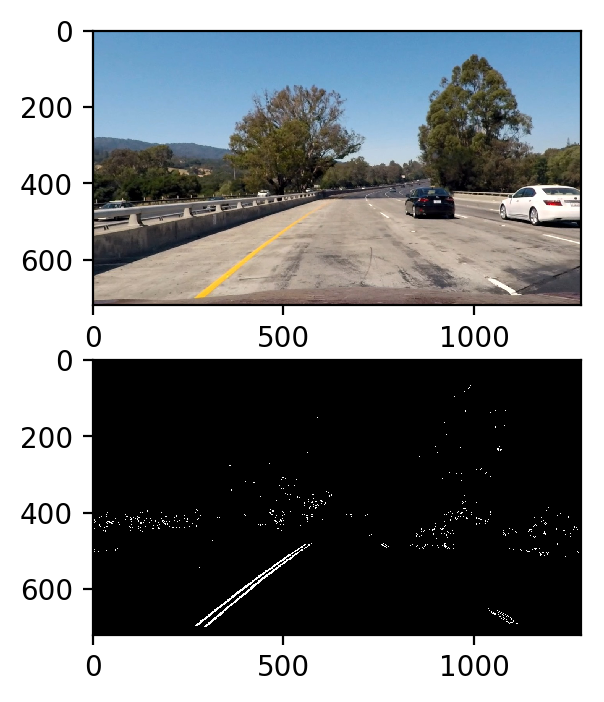

In [14]:
combined = np.zeros_like(dir_binary)
#combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
combined[((gradx == 1) & (grady == 1)) & ((mag_binary == 1) & (dir_binary == 1))] = 1

plt.figure(dpi=200)
plt.subplot(2,1,1),plt.imshow(dstImage)
plt.subplot(2,1,2),plt.imshow(combined, cmap='gray')

# Perspective Transform

In [15]:
#set source corners
srcPoint = np.float32([
    [585,460], #585,460
    [200,720], #200,720
    [1108,720],#1108,720
    [710,460]  #710,460
])
#set destinatino corners
dstPoint = np.float32([
    [320,0],
    [320,720],
    [960,720],
    [960,0]    
])

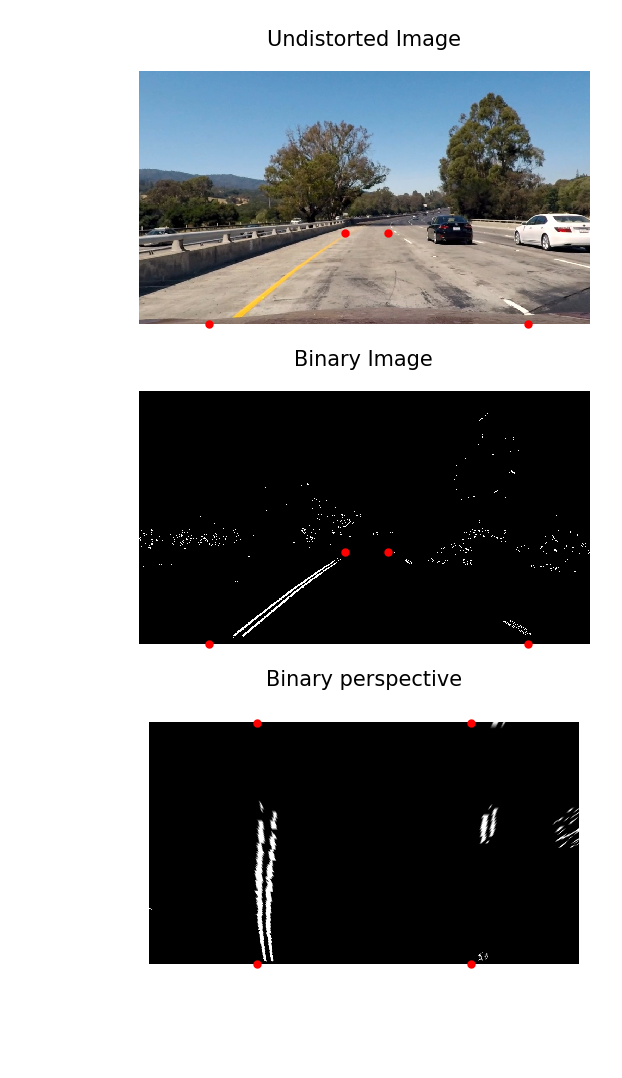

In [16]:
#get PerspectiveTransform
M = cv2.getPerspectiveTransform(srcPoint, dstPoint)
warpedImage = cv2.warpPerspective(combined, M, imgSize)

plt.figure(dpi=300)
plt.subplot(3,1,1),plt.imshow(dstImage),
plt.title('Undistorted Image',fontsize=5),plt.axis('off')
x,y = srcPoint.T
plt.scatter(x,y, s=1, color='r')

plt.subplot(3,1,2),plt.imshow(combined, cmap='gray'),
plt.title('Binary Image',fontsize=5),plt.axis('off')
plt.scatter(x,y, s=1, color='r')

plt.subplot(3,1,3),plt.imshow(warpedImage, cmap='gray'),
plt.title('Binary perspective',fontsize=5),plt.axis('off')
x,y = dstPoint.T
plt.scatter(x,y, s=1, color='r')


# Lane detection and Curve Fitting

(<matplotlib.axes._subplots.AxesSubplot at 0x7f09af71ef28>,
 (-63.950000000000003, 1342.95, -14.92783203125, 313.48447265624998))

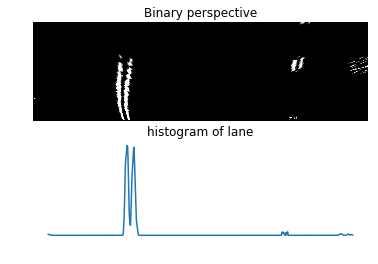

In [17]:
hist = np.sum(warpedImage[warpedImage.shape[0]//2:,:], axis=0) 
plt.subplot(2,1,1),plt.imshow(warpedImage, aspect='auto', cmap='gray'),plt.title("Binary perspective"),plt.axis('off')
plt.subplot(2,1,2),plt.plot(hist),plt.title("histogram of lane"),plt.axis('off')

In [18]:
def sliding_window_lane_finding(img, nwindows=9, margin = 100, minpix = 50, init_frame=False):
    histogram = np.sum(img[img.shape[0]//2:, :], axis=0)
    out_img = (np.dstack((img, img, img))*255).astype(np.uint8)


    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = nwindows
    window_height = np.int(img.shape[0]/nwindows)
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = margin
    # Set minimum number of pixels found to recenter window
    minpix = minpix
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    
    return out_img, left_fit, right_fit

In [19]:
out_img, left_fit, right_fit = sliding_window_lane_finding(
    warpedImage,
    nwindows=9,
    margin = 100,
    minpix = 10,
    init_frame=False)

(720, 0)

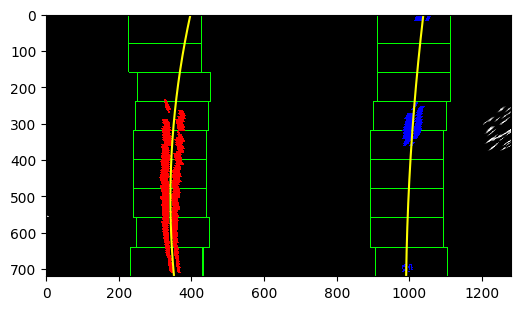

In [20]:
# Generate x and y values for plotting
ploty = np.linspace(0, warpedImage.shape[0]-1, warpedImage.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.figure(dpi=100)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# Calculate Radius of curvature and Position of Vehicle

In [21]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

In [22]:
left_curverad, right_curverad

(2352.1321118216556, 6943.4283918605706)

In [23]:
# Convert Radius to physical value from pixel value
# 30 m long and 3.7 m wide
ym_per_pix = 30./720.
xm_per_pix = 3.7/700.

left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

In [24]:
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

In [25]:
center_offset = (((left_fit[0]*720**2+left_fit[1]*720+left_fit[2])+
                    (right_fit[0]*720**2+right_fit[1]*720+right_fit[2]) ) /2 - 640)*xm_per_pix

In [26]:
left_curverad, right_curverad, center_offset

(763.05387306476109, 2279.9314947556381, 0.16702151600070916)

In [27]:
def sanity_check(left_fit, right_fit, minSlope, maxSlope):
    #refer : https://github.com/asgunzi/ArnaldoGunzi_CarNDAdvancedLaneFinding/blob/master/advancedLine.ipynb
    #Performs a sanity check on the lanes
    #Check 1: check if left and right fits exists
    #Check 2: Calculates the tangent between left and right in two points, and check if it is in a reasonable threshold
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    if len(left_fit) ==0 or len(right_fit) == 0:
        status = False
        d0=0
        d1=0
        #Previous fitlines routine returns empty list to them if not finds
    else:
        #Difference of slope
        L_0 = 2*left_fit[0]*460+left_fit[1]
        R_0 = 2*right_fit[0]*460+right_fit[1]
        d0 =  np.abs(L_0-R_0)

        L_1 = 2*left_fit[0]*720+left_fit[1]
        R_1 = 2*right_fit[0]*720+right_fit[1]
        d1 =  np.abs(L_1-R_1)

        
        if d0>= minSlope and d0<= maxSlope and d1>= minSlope and d1<= maxSlope:
            status = True
        else:
            status = False
            
    return(status, d0, d1)

In [28]:
counter = 0
status_sanity, d0, d1 =sanity_check(left_fit, right_fit, 0, .55)
#Calc curvature and center
if status_sanity  == True:        
    #Save as last reliable fit
    ref_left, ref_right = left_fit, right_fit        
    counter+=1
else:        #Use the last realible fit
    left_fit, right_fit = ref_left, ref_right

# Result (image, video)